## Import libraties

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# GeoPandas packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

import os
from zipfile import ZipFile

## Construct helper function

In [2]:
def extract_df_from_airbnb_zipfile(PATH_ZIPFILE) :
    '''
        INPUT : file path to a zipfile to open
        OUTPUT : a dictionary that contains dataframes of files 
        extracted from the zip file
    '''

    zf = ZipFile(PATH_ZIPFILE) 
    dfs = {
        text_file.filename : pd.read_csv(zf.open(text_file.filename ))
        for text_file in zf.infolist() 
        if text_file.filename.endswith('.csv')
    }
    
    print('Printing a dictionary with filenames as keys')
    for filename in dfs.keys() :
        print(f'Filename (keys): {filename}')
    
    return dfs

In [3]:
def convert_price_float(series) :

    # Remove $ & , sign from price
    rep = {'$':'', ',': ''}

    for old, new in rep.items() :
        series = series.str.replace(old, new)
        
    # convert date type to float
    series = series.astype(float)
    
    return series

## Import dataset

Boston .shp file contains multipolygon which needs to be expanded to polygons by using .explode() method

In [4]:
seattle_map = gpd.read_file('geodata/seattle/City_Clerk_Neighborhoods.shp')
boston_map = gpd.read_file('geodata/boston/Boston_Neighborhoods.shp')

In [5]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
FILE_PATH_SEATTLE = os.path.join(DATA_PATH, 'seattle.zip')
FILE_PATH_BOSTON = os.path.join(DATA_PATH, 'boston.zip')

In [6]:
dfs_seattle = extract_df_from_airbnb_zipfile(FILE_PATH_SEATTLE)
dfs_boston = extract_df_from_airbnb_zipfile(FILE_PATH_BOSTON)

Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv
Printing a dictionary with filenames as keys
Filename (keys): calendar.csv
Filename (keys): listings.csv
Filename (keys): reviews.csv


In [7]:
listings_seattle = dfs_seattle['listings.csv']
listings_boston = dfs_boston['listings.csv']

## GeoPandas

### GeoPandas mapping
Create Points with longtitude and latitude information.

In [8]:
geometry_seattle = [Point(xy) for xy in zip( listings_seattle['longitude'], listings_seattle['latitude'])]
geometry_boston = [Point(xy) for xy in zip( listings_boston['longitude'], listings_boston['latitude'])]

### Construct GeoPandas dataframe

In [10]:
gdf_seattle = gpd.GeoDataFrame(listings_seattle, geometry = geometry_seattle)
gdf_seattle = gdf_seattle.set_crs(epsg=4326)

gdf_boston = gpd.GeoDataFrame(listings_boston, geometry = geometry_boston)
gdf_seattle = gdf_seattle.set_crs(epsg=4326)

In [11]:
# Additional feature 'geometry' added onto the original dataframes 
gdf_seattle.geometry[:2], gdf_boston.geometry[:2]

(0    POINT (-122.37103 47.63629)
 1    POINT (-122.36567 47.63912)
 Name: geometry, dtype: geometry,
 0    POINT (-71.13307 42.28262)
 1    POINT (-71.13437 42.28624)
 Name: geometry, dtype: geometry)

### Visualization

In [12]:
gdf_seattle.price = convert_price_float(gdf_seattle.price)
gdf_boston.price = convert_price_float(gdf_boston.price)

In [21]:
gdf_seattle.price.describe()[3:]

min      20.0
25%      75.0
50%     100.0
75%     150.0
max    1000.0
Name: price, dtype: float64

In [24]:
seattle_price_bins = gdf_seattle.price.describe()[3:]

seattle_price_group = pd.cut(x=gdf_seattle.price, bins=seattle_price_bins.values, 
                             labels=['quartile_1', 'quartile_2', 'quartile_3', 'quartile_4'])

In [ ]:
gdf_seattle['price_group'] = seattle_price_group

In [34]:
boston_price_bins = gdf_boston.price.describe()[3:]

boston_price_group = pd.cut(x=gdf_boston.price, bins=boston_price_bins.values, 
                             labels=['quartile_1', 'quartile_2', 'quartile_3', 'quartile_4'])

In [35]:
gdf_boston['price_group'] = boston_price_group

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

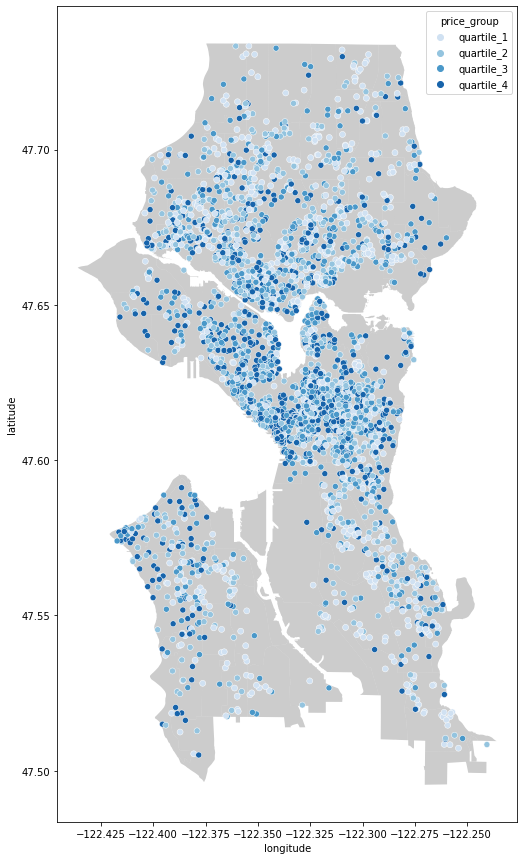

In [51]:
fig, ax = plt.subplots(figsize=(15,15))
seattle_map.plot(ax=ax, alpha=0.4, color='grey')
sns.scatterplot(data=gdf_seattle, x='longitude', y='latitude', hue='price_group', 
                palette='Blues')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

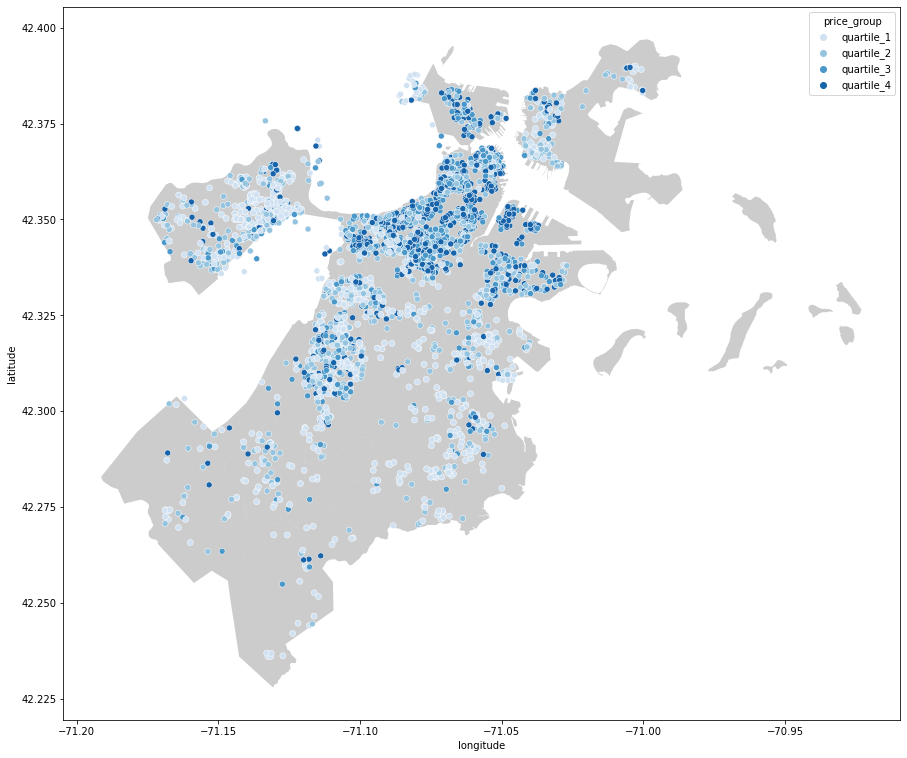

In [52]:
fig, ax = plt.subplots(figsize=(15,15))
boston_map.plot(ax=ax, alpha=0.4, color='grey')
sns.scatterplot(data=gdf_boston, x='longitude', y='latitude', hue='price_group', 
                palette='Blues')